In [ ]:
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0000_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0002_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0014_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0017_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0031_processed.tfrecord

!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0036_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0043_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0046_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0057_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0060_processed.tfrecord

!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0067_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0086_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0090_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0091_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0111_processed.tfrecord

!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0112_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0123_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0130_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0131_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0133_processed.tfrecord

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
files = ['0000', '0002', '0014', '0017', '0031', 
         '0036', '0043', '0046', '0057', '0060', 
         '0067', '0086', '0090', '0091', '0111', 
         '0112', '0123', '0130', '0131', '0133']

In [4]:
def read_dataset(file_path):
    dataset = tf.data.TFRecordDataset(file_path)

    def read_tfrecord(serialized_example):
        feature_description = {
            'thumbnail': tf.io.VarLenFeature(tf.string),
            'n_W': tf.io.FixedLenFeature((), tf.int64),
            'n_H': tf.io.FixedLenFeature((), tf.int64),
            'n_C': tf.io.FixedLenFeature((), tf.int64),
            'labels': tf.io.VarLenFeature(tf.int64),
        }
        example = tf.io.parse_single_example(serialized_example, feature_description)
        return example

    parsed_dataset = dataset.map(read_tfrecord)
    return parsed_dataset


def labeled_dataset(parsed_dataset):
    labeled_data_sets = []

    for example in parsed_dataset:
        thumbnail_bytes = example["thumbnail"].values[0].numpy()
        n_W = example["n_W"].numpy()
        n_C = example["n_C"].numpy()
        n_H = example["n_H"].numpy()

        thumbnail_arr = np.frombuffer(thumbnail_bytes, dtype=np.uint8).reshape((n_W, n_H, n_C))
        labels = example["labels"].values[0].numpy() 

        labeled_dataset = [thumbnail_arr, labels]
        labeled_data_sets.append(labeled_dataset)
    return labeled_data_sets

In [5]:
x = []
y = []
counter = [0] * 4
for number in files:
  parsed_dataset = read_dataset('/content/train' + number + '_processed.tfrecord') # ACTION NEEDED: .tfrecord file_path needs to be specified
  labeled_data_sets = labeled_dataset(parsed_dataset)
  for data in labeled_data_sets:
    if data[1] == 12:
      val = 0
    elif data[1] == 11:
      val = 1
    elif data[1] == 17:
      val = 2
    else:
      val = 3
    if counter[val] < 1000:
      resized_image = cv2.resize(data[0], (224, 224)) / 255.0
      x.append(resized_image)
      y.append(val)
      counter[val] += 1
  if counter[0] == counter[1] == counter[2] == counter[3] == 500:
    break

In [6]:
new_y = np.array(y).T
new_x = np.array(x)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3200, 224, 224, 3)
(3200, 4)
(800, 224, 224, 3)
(800, 4)


In [8]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")
base_model.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [15]:
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
checkpoint = ModelCheckpoint("resnet50.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[checkpoint, early])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.4937 - accuracy: 0.2941
Epoch 00001: val_accuracy improved from -inf to 0.36500, saving model to resnet50.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 18s 154ms/step - loss: 1.4937 - accuracy: 0.2941 - val_loss: 1.3309 - val_accuracy: 0.3650
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.3653 - accuracy: 0.3547
Epoch 00002: val_accuracy did not improve from 0.36500
100/100 [==============================] - 8s 81ms/step - loss: 1.3653 - accuracy: 0.3547 - val_loss: 1.3755 - val_accuracy: 0.3575
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.2815 - accuracy: 0.4016
Epoch 00003: val_accuracy improved from 0.36500 to 0.40875, saving model to resnet50.h5
100/100 [==============================] - 14s 139ms/step - loss: 1.2815 - accuracy: 0.4016 - val_loss: 1.2871 - val_accuracy: 0.4087
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 1.2727 - accuracy: 0.4072
Epoch 00004: val_accuracy did not improve from 0.40875
100/100 [==============================] - 8s 81ms/step - loss: 1.2727 - accuracy: 0.4072 - val_loss: 1.2819 - 

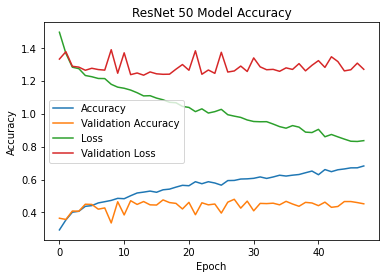

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history["loss"])
plt.plot(hist.history['val_loss'])
plt.title("ResNet 50 Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()
plt.savefig('resnet50_acc.png')

In [18]:
from keras.models import load_model
saved_model = load_model("resnet50.h5")
test_x = []
test_y = []
parsed_dataset = read_dataset('/content/train0133_processed.tfrecord') # ACTION NEEDED: .tfrecord file_path needs to be specified
labeled_data_sets = labeled_dataset(parsed_dataset)
for data in labeled_data_sets:
  if data[1] == 12:
    val = 0
  elif data[1] == 11:
    val = 1
  elif data[1] == 17:
    val = 2
  else:
    val = 3
  resized_image = cv2.resize(data[0], (224, 224)) / 255.0
  test_x.append(resized_image)
  test_y.append(val)
test_y = np.array(test_y).T
test_x = np.array(test_x)
test_y = to_categorical(test_y)
loss, acc = saved_model.evaluate(test_x, test_y)
print(loss)
print(acc)

29/29 [==============================] - 3s 61ms/step - loss: 1.3167 - accuracy: 0.4236
1.3167040348052979
0.4236186444759369
